Naïve benchmark utilisé pour la comparaison des différentes méthodes et modèles. 


Split temporel propre	
Baselines naïves (Last + Seasonal)	
Même horizon de prédiction que tes modèles	
Mêmes métriques (MAE, MSE, R²)	
Tableau comparatif	
Interprétation critique des écarts

In [2]:
import numpy as np
import sklearn as sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt 
import pandas as pd



In [ ]:
# Chargement
#df_weekly = pd.read_csv('Steam_users_10min_last_week.csv', sep=';', encoding='utf-8')
#df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])
#df_weekly = df_weekly.sort_values('DateTime').set_index('DateTime')
#df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)
#df_weekly = df_weekly.drop(columns=['Average Users'])

def build_flexible_timeseries_views(df):
    """
    df : DataFrame avec index DateTime déjà trié et colonnes numériques (Users, etc.)
    
    Retourne :
      df_daily_global  : toute la série, resamplée à 1 jour
      df_hourly_view   : partie horaire (1h + 10min agrégé à 1h), sans daily
      df_10min_view    : uniquement la partie 10min, sans hourly ni daily
    """
    df = df.sort_index().copy()
    
    # 1) Calcul des deltas temporels en secondes
    dt_seconds = df.index.to_series().diff().dt.total_seconds()

    # 2) Identifier début de chaque segment par fréquence
    #    1 jour = 86400s, 1h = 3600s, 10min = 600s
    start_hour = None
    start_10 = None
    
    if (dt_seconds == 3600).any():
        start_hour = df.index[dt_seconds == 3600].min()
    if (dt_seconds == 600).any():
        start_10 = df.index[dt_seconds == 600].min()
    
    print("Début segment horaire (1h) :", start_hour)
    print("Début segment 10min        :", start_10)
    
    # --- 1) Vue globale : toute la série resamplée à 1 jour ---
    df_daily_global = df.resample("1D").mean()
    
    # --- 2) Vue horaire : sans la partie daily ---
    # On commence à partir du début de l'horaire si disponible
    if start_hour is not None:
        df_no_daily = df.loc[start_hour:].copy()
        
        # On resample tout ça à 1h :
        # - la partie déjà horaire restera à 1h
        # - la partie 10min sera agrégée à 1h (moyenne)
        df_hourly_view = df_no_daily.resample("1H").mean()
    else:
        df_hourly_view = None
        print("Aucun segment horaire (1h) détecté, df_hourly_view = None")
    
    # --- 3) Vue 10min : uniquement la partie haute résolution ---
    if start_10 is not None:
        df_10min_view = df.loc[start_10:].copy()
        # On sécurise : resample exactement à 10min + moyenne
        df_10min_view = df_10min_view.resample("10min").mean()
    else:
        df_10min_view = None
        print(" Aucun segment 10min détecté, df_10min_view = None")
    
    return df_daily_global, df_hourly_view, df_10min_view

df_weekly = pd.read_csv('../Data/OLD/Steam_users_10min_last_week.csv', sep=';')

df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])
df_weekly = df_weekly.sort_values('DateTime').set_index('DateTime')

# Nettoyage Users (en cas de virgules pour les milliers)
df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)

# Pipeline flexible
df_daily_global, df_hourly_view, df_10min_view = build_flexible_timeseries_views(df_weekly)

print("daily:", df_daily_global.shape)
print("hourly:", None if df_hourly_view is None else df_hourly_view.shape)
print("10min:", None if df_10min_view is None else df_10min_view.shape)


data = df_hourly_view.copy()

Début segment horaire (1h) : 2025-09-21 01:00:00
Début segment 10min        : 2025-10-14 14:10:00
daily: (7953, 3)
hourly: (734, 3)
10min: (1009, 3)


/tmp/ipykernel_3177/3311161921.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly_view = df_no_daily.resample("1H").mean()


Premier benchmark naïf (version "Last value"): (t prédit = y_{t−1})

Fenêtre demandée   : 2025-09-21 00:00:00 → 2025-10-21 00:00:00
Fenêtre effective  : 2025-09-21 02:00:00 → 2025-10-21 00:00:00
Points évalués     : 719
Naïve Last Values Benchmark Metrics:
MAE  : 1,188,722.83
MSE  : 2,081,143,731,878.12
R2   : 0.9146
MAPE : 3.93 %


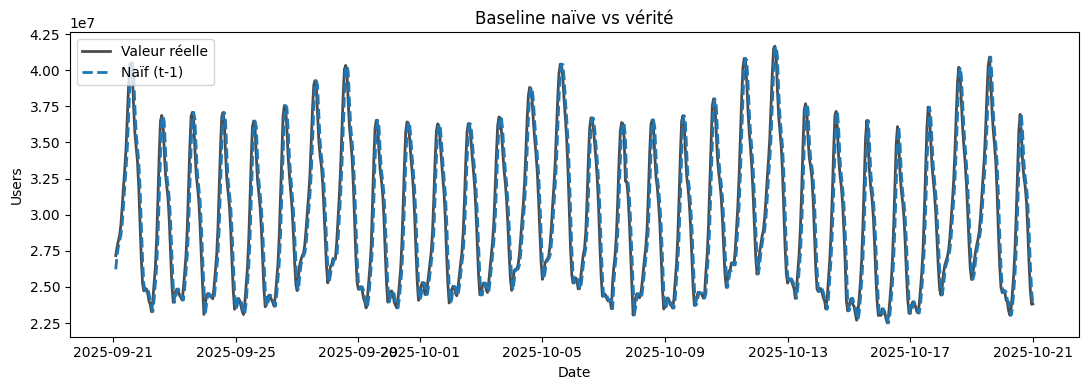

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Série daily
y = data['Users'].dropna()

# Fenêtre d'évaluation 
start_date = pd.to_datetime("2025-09-21")
end_date   = pd.to_datetime("2025-10-21")

# Vérité sur la fenêtre 
eval_true = y.loc[start_date:end_date]

# Benchmark naïf : y_hat(t) = y(t-1)
naive_last = y.shift(1).loc[eval_true.index]

# Supprimer le premier NaN si il y en a un
mask = ~naive_last.isna()
eval_true  = eval_true[mask]
naive_last = naive_last[mask]

print("Fenêtre demandée   :", start_date, "→", end_date)
print("Fenêtre effective  :", eval_true.index.min(), "→", eval_true.index.max())
print("Points évalués     :", len(eval_true))

# Métriques
mape = (np.abs((eval_true - naive_last) / np.where(eval_true == 0, 1e-9, eval_true))).mean() * 100

print("Naïve Last Values Benchmark Metrics:")
print(f"MAE  : {mean_absolute_error(eval_true, naive_last):,.2f}")
print(f"MSE  : {mean_squared_error(eval_true, naive_last):,.2f}")
print(f"R2   : {r2_score(eval_true, naive_last):,.4f}")
print(f"MAPE : {mape:,.2f} %")

# Plot
plt.figure(figsize=(11,4))
plt.plot(eval_true.index, eval_true.values, label="Valeur réelle", color="black", linewidth=2, alpha=0.7)
plt.plot(naive_last.index, naive_last.values, label="Naïf (t-1)", linestyle="--", linewidth=2)

plt.title("Baseline naïve vs vérité")
plt.xlabel("Date")
plt.ylabel("Users")
plt.legend()
plt.tight_layout()
plt.show()


Pour visualiser VS LSTM ect....

In [ ]:
#Si je veux visualiser VS LSTM

plt.figure(figsize=(13,5))

# Vérité
plt.plot(dates, true_users, label='Valeur réelle', color='black', linewidth=2, alpha=0.6)

# LSTM
plt.plot(dates, pred_users, label='LSTM', linewidth=2)

# Naïve Last
plt.plot(dates, naive_last_users, label='Baseline Naïve Last', linestyle='--', alpha=0.9)

# Naïve Seasonal (limité aux points où on a une valeur)
plt.plot(dates[mask_seasonal.to_numpy()],
         naive_seasonal_users,
         label='Baseline Naïve Saisonnière (7j)',
         linestyle='--',
         alpha=0.9)

plt.title("Comparaison des prédictions — LSTM vs Baselines Naïves")
plt.xlabel("Date")
plt.ylabel("Nombre de joueurs (daily)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
zoom_start = -7  # dernière semaine
plt.figure(figsize=(12,4))

plt.plot(dates[zoom_start:], true_users[zoom_start:], label='Vrai', linewidth=2, alpha=0.6)
plt.plot(dates[zoom_start:], pred_users[zoom_start:], label='LSTM', linewidth=2)
plt.plot(dates[zoom_start:], naive_last_users[zoom_start:], label='Naïve Last', linestyle='--')
plt.plot(dates[mask_seasonal.to_numpy()][zoom_start:],
         naive_seasonal_users[zoom_start:],
         label='Naïve Saisonnière (7j)',
         linestyle='--')

plt.title("Zoom — dernières prédictions")
plt.xlabel("Date")
plt.ylabel("Users")
plt.legend()
plt.tight_layout()
plt.show()
